In [1]:
# %load hubbard1d.py
"""
Test Lindblad based method for ground state preparation for spinful Hubbard
model.

Last revision: 05/24/2023
"""

from quspin.operators import hamiltonian
from quspin.basis import spinful_fermion_basis_1d
from quspin.tools.evolution import expm_multiply_parallel

import numpy as np # generic math functions
import scipy.linalg as la
import matplotlib.pyplot as plt
from qutip import Qobj, mesolve

from lindblad import Lindblad

# Generate Hamiltonian

In [2]:
##### define model parameters #####
L=4 # system size
J=1.0 # hopping
U=4.0 # interaction
mu=0.0 # chemical potential
# define boson basis with 3 states per site L bosons in the lattice
N_up = L//2 + L % 2 # number of fermions with spin up
N_down = L//2 # number of fermions with spin down
#    N_up = 1
#    N_down = L-1
fermion_basis = spinful_fermion_basis_1d(L,Nf=(N_up,N_down))
hop_right=[[-J,i,i+1] for i in range(L-1)] #open BC
hop_left= [[+J,i,i+1] for i in range(L-1)] #open BC
pot=[[-mu,i] for i in range(L)] # -\mu \sum_j n_{j \sigma}
interact=[[U,i,i] for i in range(L)] # U/2 \sum_j n_{j,up} n_{j,down}
# define static and dynamic lists
static=[
        ['+-|',hop_left],  # up hops left
        ['-+|',hop_right], # up hops right
        ['|+-',hop_left],  # down hops left
        ['|-+',hop_right], # down hops right
        ['n|',pot],        # up on-site potention
        ['|n',pot],        # down on-site potention
        ['n|n',interact]   # up-down interaction                      
       ]
dynamic=[]
# build Hubbard-4 Hamiltonians
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H=hamiltonian(static,dynamic,basis=fermion_basis,
        dtype=np.float64,**no_checks)
# calculate spin energy levels
E_GS,psi_GS = H.eigsh(k=1,which="SA")
psi_GS = psi_GS.flatten()
print('E_GS = ', E_GS)
H_mat = np.array(H.todense())
E_H , psi_H = la.eigh(H_mat)
gap = E_H[1] - E_H[0]
print('gap = ', gap)

E_GS =  [-1.95314531]
gap =  0.5402466127654701


# Generate Lindbald

In [3]:
a = 2.5*la.norm(H_mat,2)
da = 0.5*la.norm(H_mat,2)
b = gap
db = gap
filter_params = {'a': a, 'b': b, 'da': da, 'db': db} 
J = 1.0
A = hamiltonian([ ['+-|',[[J,0,1]]], ['-+|',[[-J,0,1]]], 
                  ['|+-',[[J,0,1]]], ['|-+',[[-J,0,1]]] ],[],basis=fermion_basis,
        dtype=np.float64,**no_checks)
A_mat = np.array(A.todense())
lb = Lindblad(H_mat, A_mat, filter_params)

# Exact Lindblad simulation

In [4]:
#set initial condition as the ground state as another Hubbard H
static_0=[
            ['+-|',hop_left],  # up hops left
            ['-+|',hop_right], # up hops right
            ['|+-',hop_left],  # down hops left
            ['|-+',hop_right], # down hops right
            ['n|',pot],        # up on-site potention
            ['|n',pot]         # down on-site potention                              
]
H0=hamiltonian(static_0,dynamic,basis=fermion_basis,
        dtype=np.float64,**no_checks)
H0_mat = np.array(H0.todense())
E_H0, psi_H0 = la.eigh(H0_mat)
# worst case: make psi0 and psi_GS orthogonal
psi0 = psi_H0[:,0]
psi0 -= psi_GS * np.vdot(psi_GS,psi0)
psi0 = psi0 / la.norm(psi0)

print('|<psi0|psiGS>| = ', np.abs(np.vdot(psi_GS,psi0)))
    
#Exact simulation
T = 100
num_t = 2*int(T)
times = np.arange(num_t+1) * (T/num_t)
H_obj = Qobj(H_mat)
rho_GS_obj = Qobj(np.outer(psi_GS, psi_GS.conj())) #initial state
lb.construct_jump_exact() #construct Jump operator
result = mesolve(H_obj, Qobj(psi0), times, [Qobj(lb.A_jump)],
            [H_obj, rho_GS_obj])
avg_energy_e = result.expect[0] #list of energy
avg_pGS_e = result.expect[1] #list of overlap

|<psi0|psiGS>| =  1.1449174941446927e-16


In [6]:
#Discrete Lindblad
# avg_energy_l: list of energy
# avg_pGS_l: list of overlap
# time_H_l: list of H simulation time
# rho_all_l: list of rho_n
S_s = 5.0 / db #Integral truncation
M_s = int(5/db/(2*np.pi/(4*a))) #Integral stepsize
num_segment = 2#discrete segment
num_rep = 100 #average repetition (used to recover \rho_n after tracing out)
times_l, avg_energy_l, avg_pGS_l, time_H_l, rho_all_l = lb.Lindblad_simulation(T, num_t,
        num_segment, psi0, num_rep, S_s, M_s,
        psi_GS, intorder=2)

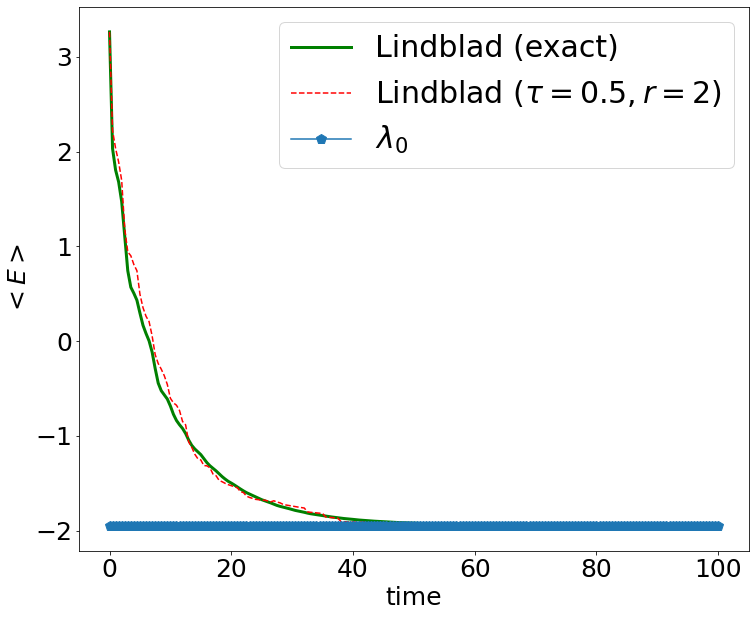

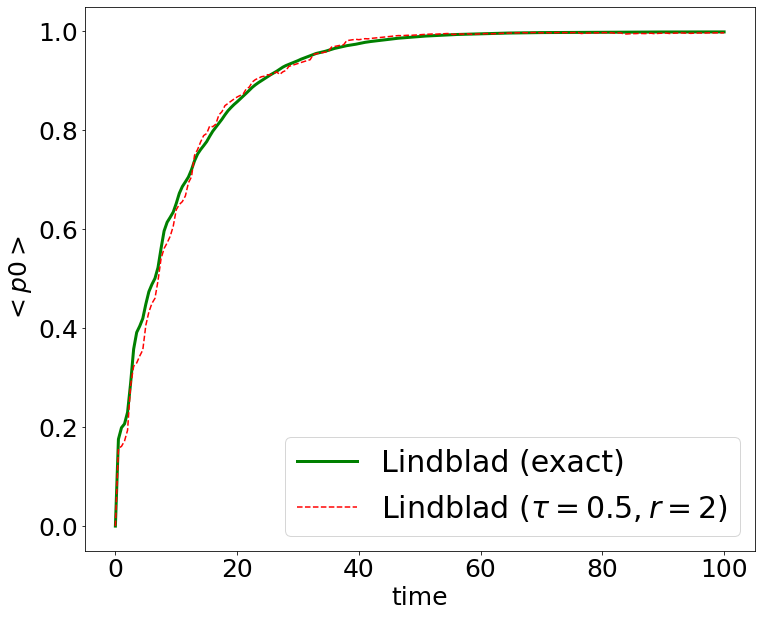

In [7]:
plt.figure(figsize=(12,10))
plt.plot(times, avg_energy_e, 'g-', label='Lindblad (exact)', linewidth=3, markersize=10)
plt.plot(times_l, avg_energy_l, 'r--', label=r'Lindblad $(\tau=0.5,r=2)$', linewidth=1.5, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_pGS_e,'g-', label=r'Lindblad (exact)', linewidth=3, markersize=20)
plt.plot(times_l, avg_pGS_l, 'r--', label=r'Lindblad $(\tau=0.5,r=2)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower right")
plt.show()

In [8]:
#Continuous Lindblad simulation
# avg_energy_s: list of energy
# avg_pGS_s: list of overlap
# time_H_s: list of H simulation time
# rho_all_s: list of rho_n
num_t = 40*int(T) #small time step
num_segment=1
times_s, avg_energy_s, avg_pGS_s, time_H_s, rho_all_s = lb.Lindblad_simulation(T, num_t,
        num_segment, psi0, num_rep, S_s, M_s,
        psi_GS, intorder=2)

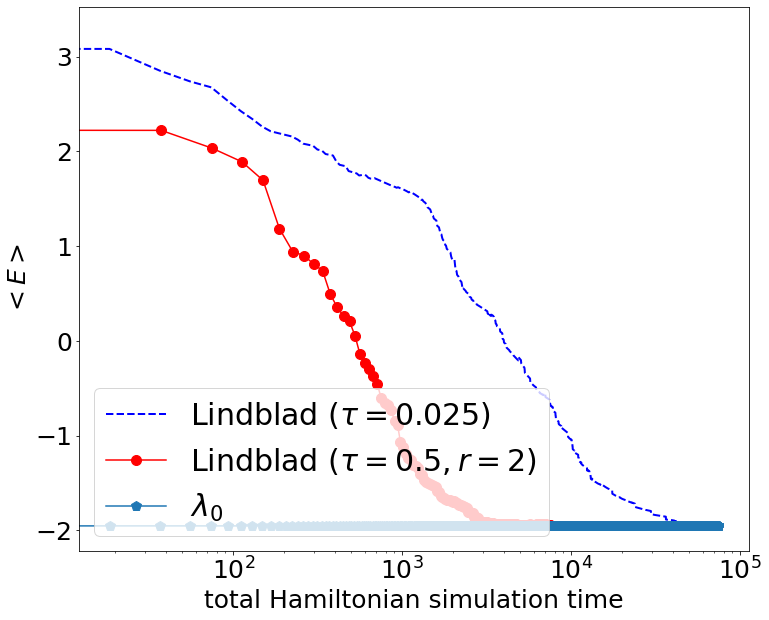

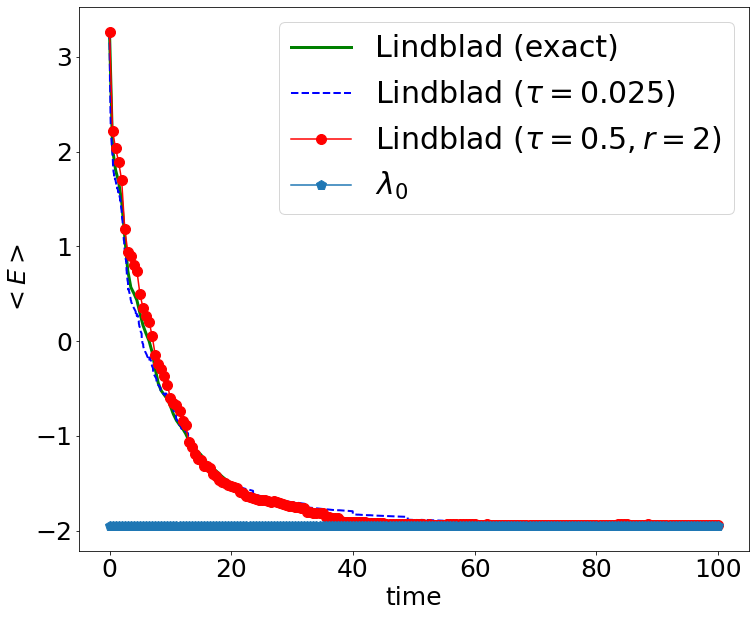

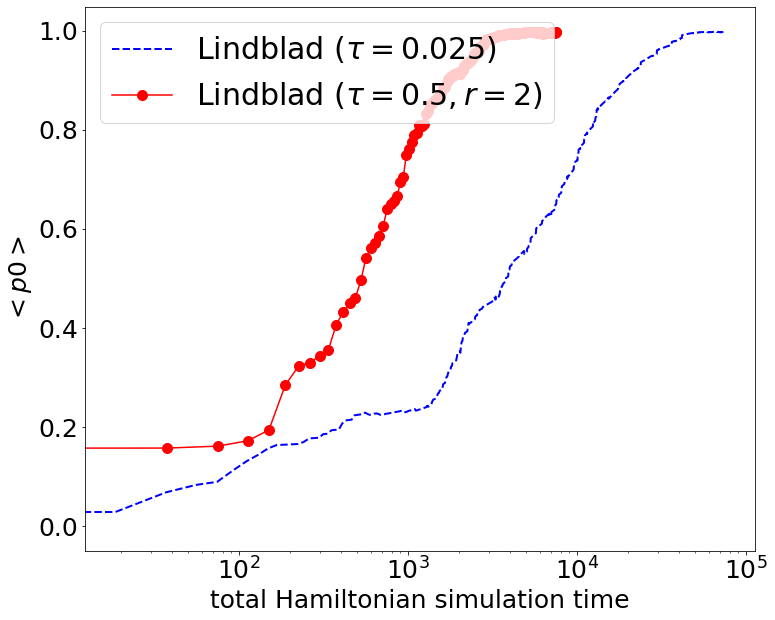

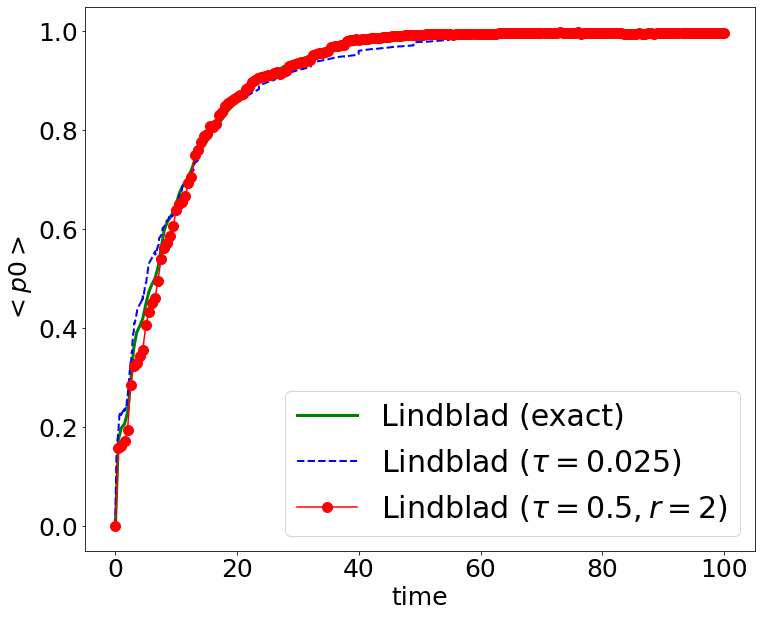

In [10]:
plt.figure(figsize=(12,10))
plt.plot(time_H_s, avg_energy_s,'b--', label=r'Lindblad $(\tau=0.025)$', linewidth=2, markersize=10)
plt.plot(time_H_l, avg_energy_l, 'r-o', label=r'Lindblad $(\tau=0.5,r=2)$', linewidth=1.5, markersize=10)
plt.plot(time_H_s, np.ones_like(time_H_s)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('total Hamiltonian simulation time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower left")
plt.savefig('Hubbard_4_energy_H_time.pdf')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_energy_e, 'g-', label='Lindblad (exact)', linewidth=3, markersize=10)
plt.plot(times_s, avg_energy_s,'b--', label=r'Lindblad $(\tau=0.025)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_energy_l, 'r-o', label=r'Lindblad $(\tau=0.5,r=2)$', linewidth=1.5, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.savefig('Hubbard_4_energy_time.pdf')
plt.show()


plt.figure(figsize=(12,10))
plt.plot(time_H_s, avg_pGS_s,'b--', label=r'Lindblad $(\tau=0.025)$', linewidth=2, markersize=10)
plt.plot(time_H_l, avg_pGS_l, 'r-o', label=r'Lindblad $(\tau=0.5,r=2)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('total Hamiltonian simulation time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="upper left")
plt.savefig('Hubbard_4_overlap_H_time.pdf')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_pGS_e,'g-', label=r'Lindblad (exact)', linewidth=3, markersize=20)
plt.plot(times_s, avg_pGS_s,'b--', label=r'Lindblad $(\tau=0.025)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_pGS_l, 'r-o', label=r'Lindblad $(\tau=0.5,r=2)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower right")
plt.savefig('Hubbard_4_overlap_time.pdf')
plt.show()